<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/Notebooks/02_basics_pytorch_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Torch basics

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [0]:
torch.__version__

'1.1.0'

Largely inspired from the tutorial [What is PyTorch?](https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html)

Tensors are used to encode the signal to process, but also the internal states and parameters of models.

**Manipulating data through this constrained structure allows to use CPUs and GPUs at peak performance.**

Construct a 3x5 matrix, uninitialized:

In [0]:
torch.set_default_tensor_type('torch.FloatTensor')

In [0]:
x = torch.empty(3,5)
print(x.type())
print(x)

torch.FloatTensor
tensor([[2.0884e-36, 0.0000e+00, 3.3631e-44, 0.0000e+00,        nan],
        [0.0000e+00, 1.1578e+27, 1.1362e+30, 7.1547e+22, 4.5828e+30],
        [1.2121e+04, 7.1846e+22, 9.2198e-39, 0.0000e+00, 0.0000e+00]])


If you got an error this [stackoverflow link](https://stackoverflow.com/questions/50617917/overflow-when-unpacking-long-pytorch) might be useful...

In [0]:
x = torch.randn(3,5)
print(x)

tensor([[ 0.1856,  0.9792, -0.4283, -1.0757,  0.7362],
        [-1.0529,  1.2873, -0.5523, -0.1145,  0.6524],
        [ 1.2563,  0.6666,  1.1430,  0.6110,  0.9028]])


In [0]:
print(x.size(0))

3


torch.Size is in fact a [tuple](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences), so it supports the same operations.

In [0]:
x.size()[1]

5

In [0]:
x.size() == (3,5)

True

### Bridge to numpy

In [0]:
y = x.numpy()
print(y)

[[ 0.18560591  0.9791916  -0.42826343 -1.0757245   0.73624367]
 [-1.0528868   1.287336   -0.55225486 -0.11451106  0.6523747 ]
 [ 1.2562817   0.66656756  1.1430092   0.6110474   0.9027767 ]]


In [0]:
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
c = torch.from_numpy(a)
print(b)

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


In [0]:
xr = torch.randn(3, 5)
print(xr)

tensor([[-0.7665, -0.1489,  0.2337,  0.5753,  0.4726],
        [ 2.6880,  0.2332,  1.0229, -0.3940,  0.5060],
        [ 0.0350, -0.0374,  1.5060,  0.3925, -0.1189]])


In [0]:
xr + b

RuntimeError: ignored

In [0]:
# solve this bug!
b = b.float()

In [0]:
xr+b

tensor([[0.2335, 0.8511, 1.2337, 1.5753, 1.4726],
        [3.6880, 1.2332, 2.0229, 0.6060, 1.5060],
        [1.0350, 0.9626, 2.5060, 1.3925, 0.8811]])

In [0]:
print(x+xr)

tensor([[-0.5809,  0.8303, -0.1946, -0.5004,  1.2088],
        [ 1.6351,  1.5205,  0.4707, -0.5085,  1.1584],
        [ 1.2913,  0.6292,  2.6490,  1.0035,  0.7839]])


In [0]:
x.add(xr)
print(x)

tensor([[-1.3473,  0.6813,  0.0391,  0.0749,  1.6814],
        [ 4.3231,  1.7537,  1.4936, -0.9025,  1.6645],
        [ 1.3264,  0.5918,  4.1551,  1.3960,  0.6650]])

Any operation that mutates a tensor in-place is post-fixed with an ```_```

For example: ```x.copy_(y)```, ```x.t_()```, will change ```x```.

In [0]:
print(x.t())

tensor([[-0.5809,  1.6351,  1.2913],
        [ 0.8303,  1.5205,  0.6292],
        [-0.1946,  0.4707,  2.6490],
        [-0.5004, -0.5085,  1.0035],
        [ 1.2088,  1.1584,  0.7839]])


In [0]:
x.t_()
print(x)

tensor([[-0.5809,  1.6351,  1.2913],
        [ 0.8303,  1.5205,  0.6292],
        [-0.1946,  0.4707,  2.6490],
        [-0.5004, -0.5085,  1.0035],
        [ 1.2088,  1.1584,  0.7839]])


Also be careful, changing the torch tensor modify the numpy array and vice-versa...

In [0]:
np.add(a, 1, out=a)
print(b)
print(c)

tensor([1., 1., 1., 1., 1.])
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


In [0]:
torch.cuda.is_available()

True

In [0]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [0]:
x.device

device(type='cpu')

In [0]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

tensor([[0.4191, 2.6351, 2.2913],
        [1.8303, 2.5205, 1.6292],
        [0.8054, 1.4707, 3.6490],
        [0.4996, 0.4915, 2.0035],
        [2.2088, 2.1584, 1.7839]], device='cuda:0')
tensor([[0.4191, 2.6351, 2.2913],
        [1.8303, 2.5205, 1.6292],
        [0.8054, 1.4707, 3.6490],
        [0.4996, 0.4915, 2.0035],
        [2.2088, 2.1584, 1.7839]], dtype=torch.float64)


In [0]:
x = torch.randn(1)
x = x.to(device)

In [0]:
# the following line is only useful if CUDA is available
x = x.data
print(x)
print(x.item())
print(x.to('cpu').numpy())

tensor([0.3411], device='cuda:0')
0.3411146104335785
[0.3411146]


# Datasets

torchvision is a handy interface to download classic datasets such as MNIST, CIFAR10, CIFAR100...

In [0]:
import torchvision

data_dir = '.'

cifar = torchvision.datasets.CIFAR10(data_dir, train = True, download = True)
x = torch.from_numpy(cifar.data).transpose(1, 3).transpose(2, 3).float()
x = x / 255
print(x.type(), x.size(), x.min().item(), x.max().item())

0it [00:00, ?it/s]

 99%|█████████▉| 169418752/170498071 [00:12<00:00, 14301902.48it/s]

torch.FloatTensor torch.Size([50000, 3, 32, 32]) 0.0 1.0


In [0]:
x = torch.from_numpy(cifar.data).transpose(1, 3).transpose(2, 3).float()
x = x / 255
print(x.type(), x.size(), x.min().item(), x.max().item())

torch.FloatTensor torch.Size([50000, 3, 32, 32]) 0.0 1.0


In [0]:
# Narrows to the first images, converts to float
x = x.narrow(0, 0, 48).float()

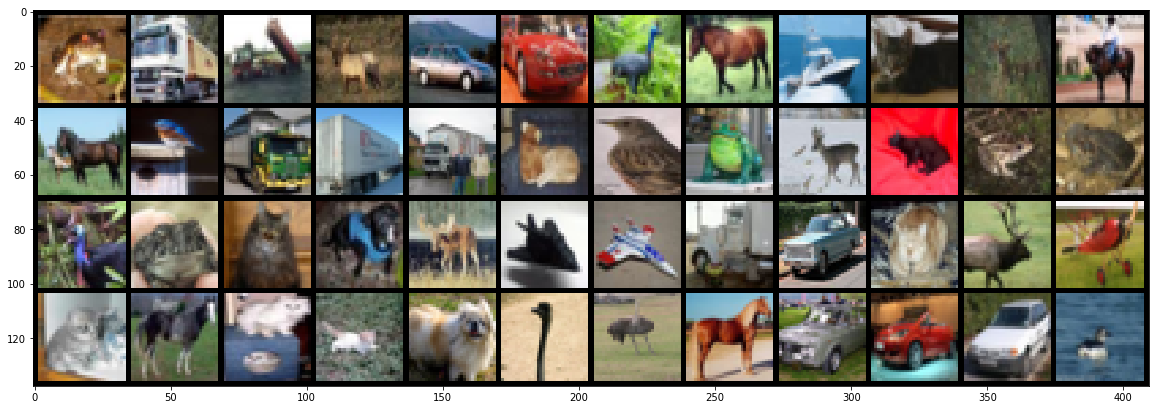

In [0]:
# Showing images
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
show(torchvision.utils.make_grid(x, nrow = 12))

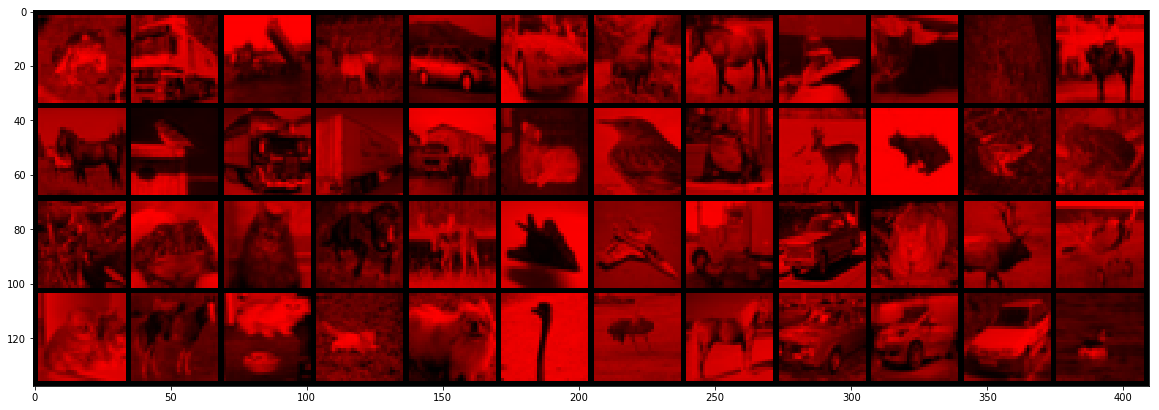

In [0]:
# Kills the green and blue channels
x.narrow(1, 1, 2).fill_(0)
show(torchvision.utils.make_grid(x, nrow = 12))

## Dataloaders

The DataLoader tool bunches the dataset into batches

In [0]:
t_func = torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])
mnist_train = torchvision.datasets.MNIST('.', train = True, download = True, transform = t_func)
mnist_test = torchvision.datasets.MNIST ('.', train = False, download = True, transform = t_func)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(mnist_test , batch_size=64, shuffle=False)

In [0]:
cifar = torchvision.datasets.CIFAR10(data_dir, train = True, download = True, transform = t_func)
train_loader = torch.utils.data.DataLoader(cifar, batch_size=64, shuffle=True)

Files already downloaded and verified


In [0]:
for (x,y) in train_loader:
    print(x)
    print(y)
    break

tensor([[[[ 0.3268,  0.4413,  0.6450,  ...,  0.4159,  0.0467, -0.0678],
          [ 0.8868,  1.0523,  1.1541,  ...,  0.5304,  0.2249,  0.1358],
          [ 0.8868,  0.9886,  1.0777,  ...,  0.6195,  0.5049,  0.5431],
          ...,
          [ 0.4922,  0.5431,  0.6577,  ...,  1.2050,  1.0904,  1.0777],
          [ 0.5559,  0.6195,  0.6322,  ...,  1.0904,  1.0013,  0.8868],
          [ 0.7341,  0.7086,  0.8486,  ...,  0.9886,  0.9250,  0.9123]],

         [[ 0.9632,  1.0268,  1.1923,  ...,  1.0395,  0.6577,  0.5431],
          [ 1.4468,  1.5614,  1.6378,  ...,  1.1159,  0.8104,  0.7213],
          [ 1.4214,  1.4723,  1.5359,  ...,  1.2050,  1.0904,  1.1286],
          ...,
          [ 1.0395,  1.0395,  1.1159,  ...,  1.8032,  1.6887,  1.6632],
          [ 1.1286,  1.1286,  1.1032,  ...,  1.7905,  1.7014,  1.5741],
          [ 1.3450,  1.2559,  1.3705,  ...,  1.7269,  1.6505,  1.6250]],

         [[ 0.6195,  0.6577,  0.7977,  ...,  0.7468,  0.3649,  0.2377],
          [ 0.9632,  1.0650,  

# Autograd: automatic differentiation

When executing tensor operations, PyTorch can automatically construct on-the-fly the graph of operations to compute the gradient of any quantity with respect to any tensor involved.

In [0]:
x = torch.ones(2, 2)
print(x)

tensor([[1., 1.],
        [1., 1.]])


A Tensor has a Boolean field *requires_grad*, set to False by default, which states if PyTorch should build the graph of operations so that gradients wrt to it can be computed.

In [0]:
x.requires_grad

False

In [0]:
x.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [0]:
x.requires_grad_(True)
x.requires_grad

True

In [0]:
x.detach().numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [0]:
x.data.numpy()

array([[1., 1.],
       [1., 1.]], dtype=float32)

In [0]:
x.requires_grad

True

In [0]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


[Broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html) again!

Broadcasting automagically expands dimensions by replicating coefficients, when it is necessary to perform operations.

1. If one of the tensors has fewer dimensions than the other, it is reshaped by adding as many dimensions of size 1 as necessary in the front; then
2. for every mismatch, if one of the two tensor is of size one, it is expanded along this axis by replicating  coefficients.

If there is a tensor size mismatch for one of the dimension and neither of them is one, the operation fails.

In [0]:
A = torch.tensor([[1.], [2.], [3.], [4.]])
print(A.size())
B = torch.tensor([[5., -5., 5., -5., 5.]])
print(B.size())
C = A + B

torch.Size([4, 1])
torch.Size([1, 5])


In [0]:
C

tensor([[ 6., -4.,  6., -4.,  6.],
        [ 7., -3.,  7., -3.,  7.],
        [ 8., -2.,  8., -2.,  8.],
        [ 9., -1.,  9., -1.,  9.]])

Back to Autograd!

In [0]:
y.requires_grad

True

In [0]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


After the computation is finished, i.e. _forward pass_, you can call ```.backward()``` and have all the gradients computed automatically.

In [0]:
out.backward()

The gradients w.r.t. this variable is accumulated into ```.grad```.

In [0]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


Let’s call the ``out``
*Variable* “$o$”.
We have that:

$y_i = x_i+2$

$z_i = 3 y_i^2$ 

$o = \frac{1}{4}\sum_i z_i$ 

**Forward pass:**

$y_i\bigr\rvert_{x_i=1} = 3$

$z_i\bigr\rvert_{y_i=3} = 27$

$o\bigr\rvert_{z_i=27} = 27$.

Taking partial derivatives give:

$\frac{\partial o}{\partial z_i} = \frac{1}{4}$

$\frac{\partial z_i}{\partial y_i} = 6 y_i$

$\frac{\partial y_i}{\partial x_i} =1$


hence by the **chain-rule:**

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{\partial o}{\partial z_i}\bigr\rvert_{z_i=27}\frac{\partial z_i}{\partial y_i}\bigr\rvert_{y_i=3}\frac{\partial y_i}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{1}{4} * 18 * 1 = 4.5$.

In [0]:
print(y.grad)

None


[Why cant I see .grad of an intermediate variable?](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94)

In [0]:
out.backward()

RuntimeError: ignored

In [0]:
x = torch.ones(2, 2)
x.requires_grad_(True)
y = x+2
z = 3 * y ** 2 
out = z.mean()

out.backward(retain_graph=True)

In [0]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [0]:
torch.autograd.grad(out, z, retain_graph=True)

(tensor([[0.2500, 0.2500],
         [0.2500, 0.2500]]),)

In [0]:
torch.autograd.grad(out, y, retain_graph=True)

(tensor([[4.5000, 4.5000],
         [4.5000, 4.5000]]),)

In [0]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


In [0]:
out.backward(retain_graph=True)

In [0]:
print(x.grad)

tensor([[9., 9.],
        [9., 9.]])


In [0]:
out.backward(torch.Tensor([2.0]), retain_graph=True)

In [0]:
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


In [0]:
# Manually zero the gradients after updating weights
x.grad.data.zero_()

tensor([[0., 0.],
        [0., 0.]])

The gradients must be set to zero manually. Otherwise they will cumulate across several _.backward()_ calls. 
This accumulating behavior is desirable in particular to compute the gradient of a loss summed over several “mini-batches,” or the gradient of a sum of losses.


In [0]:
out.backward()

In [0]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


If you want to come back to the difference between detach and data see [Differences between .data and .detach](https://github.com/pytorch/pytorch/issues/6990)

# Playing with pytorch: linear regression

## Warm-up: Linear regression with numpy

Our model is:
$$
y_t = 2x^1_t-3x^2_t+1, \quad t\in\{1,\dots,30\}
$$

Our task is given the 'observations' $(x_t,y_t)_{t\in\{1,\dots,30\}}$ to recover the weights $w^1=2, w^2=-3$ and the bias $b = 1$.

In order to do so, we will solve the following optimization problem:
$$
\underset{w^1,w^2,b}{\operatorname{argmin}} \sum_{t=1}^{30} \left(w^1x^1_t+w^2x^2_t+b-y_t\right)^2
$$

In [0]:
import numpy as np
from numpy.random import random
# generate random input data
x = random((30,2))

# generate labels corresponding to input data x
y = np.dot(x, [2., -3.]) + 1.
w_source = np.array([2., -3.])
b_source  = np.array([1.])

In [0]:
x[:5]

array([[0.73631343, 0.85228052],
       [0.46331508, 0.97062475],
       [0.71083207, 0.57374426],
       [0.30227967, 0.8846787 ],
       [0.98681171, 0.37748084]])

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_figs(fig_num, elev, azim, x, y, weights, bias):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)
    ax.scatter(x[:, 0], x[:, 1], y)
    ax.plot_surface(np.array([[0, 0], [1, 1]]),
                    np.array([[0, 1], [0, 1]]),
                    (np.dot(np.array([[0, 0, 1, 1],
                                          [0, 1, 0, 1]]).T, weights) + bias).reshape((2, 2)),
                    alpha=.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    
def plot_views(x, y, w, b):
    #Generate the different figures from different views
    elev = 43.5
    azim = -110
    plot_figs(1, elev, azim, x, y, w, b[0])

    plt.show()

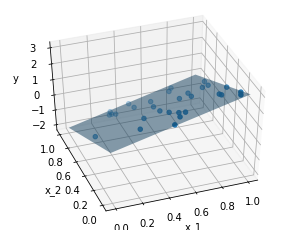

In [0]:
plot_views(x, y, w_source, b_source)

In vector form, we define:
$$
\hat{y}_t = {\bf w}^T{\bf x}_t+b
$$
and we want to minimize the loss given by:
$$
loss = \sum_t\underbrace{\left(\hat{y}_t-y_t \right)^2}_{loss_t}.
$$

To minimize the loss we first compute the gradient of each $loss_t$:
\begin{eqnarray*}
\frac{\partial{loss_t}}{\partial w^1} &=& 2x^1_t\left({\bf w}^T{\bf x}_t+b-y_t \right)\\
\frac{\partial{loss_t}}{\partial w^2} &=& 2x^2_t\left({\bf w}^T{\bf x}_t+b-y_t \right)\\
\frac{\partial{loss_t}}{\partial b} &=& 2\left({\bf w}^T{\bf x}_t+b-y_t \right)
\end{eqnarray*}

For one epoch, **Stochastic Gradient Descent with minibatches of size 1** then updates the weigts and bias by running the following loop: 

for $t \in \{1,\dots,30\}$, 

\begin{eqnarray*}
w^1_{t+1}&=&w^1_{t}-\alpha\frac{\partial{loss_t}}{\partial w^1} \\
w^2_{t+1}&=&w^2_{t}-\alpha\frac{\partial{loss_t}}{\partial w^2} \\
b_{t+1}&=&b_{t}-\alpha\frac{\partial{loss_t}}{\partial b},
\end{eqnarray*}

if $t = 30$, set $w^1_1=w^1_{31}$, $w^2_1 = w^2_{31}$ and $b_1=b_{31}$.

$\alpha>0$ is called the learning rate.

Then we run several epochs...

In [0]:
# randomly initialize learnable weights and bias
w_init = random(2)
b_init = random(1)

w = w_init
b = b_init
print("initial values of the parameters:", w, b )


# our model forward pass
def forward(x):
    return x.dot(w)+b

# Loss function
def loss(x, y):
    y_pred = forward(x)
    return (y_pred - y)**2 

print("initial loss:", np.sum([loss(x_val,y_val) for x_val, y_val in zip(x, y)]) )

# compute gradient
def gradient(x, y):  # d_loss/d_w, d_loss/d_c
    return 2*(x.dot(w)+b - y)*x, 2 * (x.dot(w)+b - y)
 
learning_rate = 1e-2
# Training loop with minibatch (of size 1)
for epoch in range(10):
    l = 0
    for x_val, y_val in zip(x, y):
        grad_w, grad_b = gradient(x_val, y_val)
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        l += loss(x_val, y_val)

    print("progress:", "epoch:", epoch, "loss",l[0])

# After training
print("estimation of the parameters:", w, b )

initial values of the parameters: [0.81229907 0.38792425] [0.00444522]
initial loss: 35.83879146315113
progress: epoch: 0 loss 32.2680707549873
progress: epoch: 1 loss 28.851248193500435
progress: epoch: 2 loss 25.82407763829883
progress: epoch: 3 loss 23.12893233245537
progress: epoch: 4 loss 20.72502331293791
progress: epoch: 5 loss 18.579242514998604
progress: epoch: 6 loss 16.663133377256916
progress: epoch: 7 loss 14.951680502118649
progress: epoch: 8 loss 13.422702470938548
progress: epoch: 9 loss 12.056465705595956
estimation of the parameters: [ 1.56295368 -0.92658847] [0.19412941]


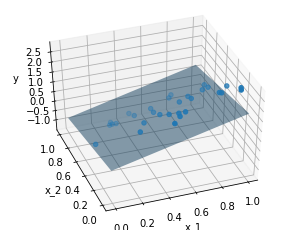

In [0]:
plot_views(x, y, w, b)

Note that the actual gradient of the loss is given by:
$$
\frac{\partial{loss}}{\partial w^1} =\sum_t \frac{\partial{loss_t}}{\partial w^1},\quad
\frac{\partial{loss}}{\partial w^2} =\sum_t \frac{\partial{loss_t}}{\partial w^2},\quad
\frac{\partial{loss}}{\partial b} =\sum_t \frac{\partial{loss_t}}{\partial b}
$$

For one epoch, **(Batch) Gradient Descent** updates the weights and bias as follows:
\begin{eqnarray*}
w^1_{new}&=&w^1_{old}-\alpha\frac{\partial{loss}}{\partial w^1} \\
w^2_{new}&=&w^2_{old}-\alpha\frac{\partial{loss}}{\partial w^2} \\
b_{new}&=&b_{old}-\alpha\frac{\partial{loss}}{\partial b},
\end{eqnarray*}

and then we run several epochs.

Exercice: explain the difference between the 2 schemes?

In [0]:
w = w_init
b = b_init
print("initial values of the parameters:", w, b )

learning_rate = 1e-2
# Training loop
for epoch in range(10):
    grad_w = np.array([0,0])
    grad_b = np.array(0)
    l = 0
    for x_val, y_val in zip(x, y):
        grad_w = np.add(grad_w,gradient(x_val, y_val)[0])
        grad_b = np.add(grad_b,gradient(x_val, y_val)[1])
        l += loss(x_val, y_val)
    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b
    print("progress:", "epoch:", epoch, "loss",l[0])

# After training
print("estimation of the parameters:", w, b)

initial values of the parameters: [0.81229907 0.38792425] [0.00444522]
progress: epoch: 0 loss 35.838791463151125
progress: epoch: 1 loss 31.644021633641653
progress: epoch: 2 loss 28.286763055004464
progress: epoch: 3 loss 25.29494262415122
progress: epoch: 4 loss 22.62836913157744
progress: epoch: 5 loss 20.251359938598473
progress: epoch: 6 loss 18.13215876291585
progress: epoch: 7 loss 16.242503210478368
progress: epoch: 8 loss 14.55723997327301
progress: epoch: 9 loss 13.053982421702369
estimation of the parameters: [ 1.55710351 -0.95554274] [0.15200585]


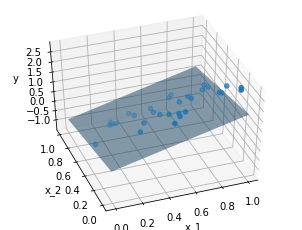

In [0]:
plot_views(x, y, w, b)

## Linear regression with tensors

In [0]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [0]:
x_t = torch.from_numpy(x).type(dtype)
y_t = torch.from_numpy(y).type(dtype).unsqueeze(1)

This is an implementation of **(Batch) Gradient Descent** with tensors.

Note that in the main loop, the functions loss_t and gradient_t are always called with the same inputs: they can easily be incorporated into the loop (we'll do that below).

In [0]:
w_init_t = torch.from_numpy(w_init).type(dtype)
b_init_t = torch.from_numpy(b_init).type(dtype)

w_t = w_init_t.clone()
w_t.unsqueeze_(1)
b_t = b_init_t.clone()
b_t.unsqueeze_(1)
print("initial values of the parameters:", w_t, b_t )

# our model forward pass
def forward_t(x):
    return x.mm(w_t)+b_t

# Loss function
def loss_t(x, y):
    y_pred = forward_t(x)
    return (y_pred - y).pow(2).sum()

# compute gradient
def gradient_t(x, y):  # d_loss/d_w, d_loss/d_c
    return 2*torch.mm(torch.t(x),x.mm(w_t)+b_t - y), 2 * (x.mm(w_t)+b_t - y).sum()

learning_rate = 1e-2
for epoch in range(10):
    l_t = loss_t(x_t,y_t)
    grad_w, grad_b = gradient_t(x_t,y_t)
    w_t = w_t-learning_rate*grad_w
    b_t = b_t-learning_rate*grad_b
    print("progress:", "epoch:", epoch, "loss",l_t)

# After training
print("estimation of the parameters:", w_t, b_t )

initial values of the parameters: tensor([[0.8123],
        [0.3879]]) tensor([[0.0044]])
progress: epoch: 0 loss tensor(35.8388)
progress: epoch: 1 loss tensor(31.6440)
progress: epoch: 2 loss tensor(28.2868)
progress: epoch: 3 loss tensor(25.2949)
progress: epoch: 4 loss tensor(22.6284)
progress: epoch: 5 loss tensor(20.2514)
progress: epoch: 6 loss tensor(18.1322)
progress: epoch: 7 loss tensor(16.2425)
progress: epoch: 8 loss tensor(14.5572)
progress: epoch: 9 loss tensor(13.0540)
estimation of the parameters: tensor([[ 1.5571],
        [-0.9555]]) tensor([[0.1520]])


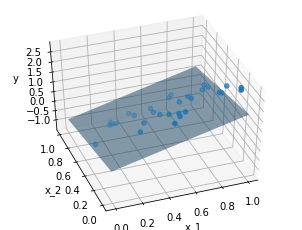

In [0]:
plot_views(x, y, w_t.numpy(), b_t.numpy())

## Linear regression with Autograd

In [0]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w_v = w_init_t.clone().unsqueeze(1)
w_v.requires_grad_(True)
b_v = b_init_t.clone().unsqueeze(1)
b_v.requires_grad_(True)
print("initial values of the parameters:", w_v.data, b_v.data )

initial values of the parameters: tensor([[0.8123],
        [0.3879]]) tensor([[0.0044]])


An implementation of **(Batch) Gradient Descent** without computing explicitly the gradient and using autograd instead.

In [0]:
for epoch in range(10):
    y_pred = x_t.mm(w_v)+b_v
    loss = (y_pred - y_t).pow(2).sum()
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Variables with requires_grad=True.
    # After this call w.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to w and b respectively.
    loss.backward()
    
    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w_v and b_v in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w_v -= learning_rate * w_v.grad
        b_v -= learning_rate * b_v.grad
    
    # Manually zero the gradients after updating weights
    # otherwise gradients will be acumulated after each .backward()
    w_v.grad.zero_()
    b_v.grad.zero_()
    
    print("progress:", "epoch:", epoch, "loss",loss.data.item())

# After training
print("estimation of the parameters:", w_v.data, b_v.data.t() )

progress: epoch: 0 loss 35.83878707885742
progress: epoch: 1 loss 31.644020080566406
progress: epoch: 2 loss 28.28676414489746
progress: epoch: 3 loss 25.294946670532227
progress: epoch: 4 loss 22.628366470336914
progress: epoch: 5 loss 20.25135612487793
progress: epoch: 6 loss 18.132158279418945
progress: epoch: 7 loss 16.242502212524414
progress: epoch: 8 loss 14.55724048614502
progress: epoch: 9 loss 13.053982734680176
estimation of the parameters: tensor([[ 1.5571],
        [-0.9555]]) tensor([[0.1520]])


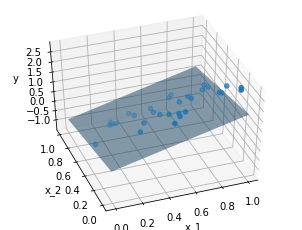

In [0]:
plot_views(x, y, w_v.data.numpy(), b_v.data.numpy())

## Linear regression with neural network

An implementation of **(Batch) Gradient Descent** using the nn package. Here we have a super simple model with only one layer and no activation function!

In [0]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1)
)

for m in model.children():
    m.weight.data = w_init_t.clone().unsqueeze(0)
    m.bias.data = b_init_t.clone()

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(size_average=False)

# switch to train mode
model.train()

for epoch in range(10):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Variable of input data to the Module and it produces
    # a Variable of output data.
    y_pred = model(x_t)
  
    # Note this operation is equivalent to: pred = model.forward(x_v)

    # Compute and print loss. We pass Variables containing the predicted and true
    # values of y, and the loss function returns a Variable containing the
    # loss.
    loss = loss_fn(y_pred, y_t)

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Variables with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad
        
    print("progress:", "epoch:", epoch, "loss",loss.data.item())

# After training
print("estimation of the parameters:")
for param in model.parameters():
    print(param)

progress: epoch: 0 loss 35.83879089355469
progress: epoch: 1 loss 31.64402198791504
progress: epoch: 2 loss 28.28676414489746
progress: epoch: 3 loss 25.29494285583496
progress: epoch: 4 loss 22.628368377685547
progress: epoch: 5 loss 20.251359939575195
progress: epoch: 6 loss 18.132158279418945
progress: epoch: 7 loss 16.242502212524414
progress: epoch: 8 loss 14.557239532470703
progress: epoch: 9 loss 13.053982734680176
estimation of the parameters:
Parameter containing:
tensor([[ 1.5571, -0.9555]], requires_grad=True)
Parameter containing:
tensor([0.1520], requires_grad=True)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Last step, we use directly the optim package to update the weights and bias.

In [0]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
)

for m in model.children():
    m.weight.data = w_init_t.clone().unsqueeze(0)
    m.bias.data = b_init_t.clone()

loss_fn = torch.nn.MSELoss(size_average=False)

model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for epoch in range(10):
    y_pred = model(x_t)
    loss = loss_fn(y_pred, y_t)
    print("progress:", "epoch:", epoch, "loss",loss.item())
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
# After training
print("estimation of the parameters:")
for param in model.parameters():
    print(param)

progress: epoch: 0 loss 35.83879089355469
progress: epoch: 1 loss 31.64402198791504
progress: epoch: 2 loss 28.28676414489746
progress: epoch: 3 loss 25.29494285583496
progress: epoch: 4 loss 22.628368377685547
progress: epoch: 5 loss 20.251359939575195
progress: epoch: 6 loss 18.132158279418945
progress: epoch: 7 loss 16.242502212524414
progress: epoch: 8 loss 14.557239532470703
progress: epoch: 9 loss 13.05398178100586
estimation of the parameters:
Parameter containing:
tensor([[ 1.5571, -0.9555]], requires_grad=True)
Parameter containing:
tensor([0.1520], requires_grad=True)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


#Exercises

## Exercise 1: Try to improve performance

## Exercise 2: Logistic regression

Sigmoid function:
$$
\sigma(y) = \frac{1}{1+e^{-y}}
$$

The model is now
$$
Z_t = Ber(\sigma(y_t)), \quad t\in\{1,\dots,30\},
$$
and the task is still to recover the weights $w^1=2, w^2=-3$ and the bias $b = 1$ but now from the observations $(x_t,Z_t)_{t\in \{1,\dots,30\}}$.

In [0]:
from scipy.special import expit
xaxis = np.arange(-10.0, 10.0, 0.1)
plt.plot(xaxis,[expit(x) for x in xaxis]);

You might need to install scipy first by runing:

$ pip3 install scipy

In [0]:
from scipy.stats import bernoulli
Z = bernoulli.rvs(expit(y))

What is an appropriate loss function now?

## Exercise 3: Perceptron on MNIST

Run a perceptron on MNIST.